# XGBoost for Heart Disease Prediction: A Comprehensive Tutorial
# 1. Introduction
- Heart disease remains one of the leading causes of mortality worldwide, accounting for approximately 32% of all deaths globally. Early and accurate prediction of heart disease can significantly improve patient outcomes through timely intervention and treatment.
- Machine learning algorithms have shown remarkable potential in medical diagnostics by identifying patterns in patient data that might not be immediately apparent to human clinicians. Among these algorithms, ensemble methods like XGBoost have demonstrated exceptional performance in various healthcare applications.

### What is XGBoost?
XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithms designed for speed and performance. It works by building an ensemble of decision trees sequentially, where each new tree corrects the errors made by the previous trees.

**Key advantages of XGBoost include:**

- High performance: Optimized for both speed and prediction accuracy
- Regularization: Built-in capabilities to prevent overfitting
- Handling missing values: Can work with incomplete data
- Flexibility: Works well with various types of data and problems

In this tutorial, we will explore how to use XGBoost to predict heart disease based on patient characteristics and medical measurements. We'll walk through each step of the machine learning workflow, from data exploration to model interpretation.

## 2. Setting Up the Environment
Before we begin, let's import the necessary libraries and set up our environment. Each library serves a specific purpose in our analysis:

In [3]:
!pip install lime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap
from lime import lime_tabular
import warnings
import os
from datetime import datetime
plt.style.use('ggplot')
sns.set(font_scale=1.2)
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=1c7dc2020e24690db52c052d432cdfaf698e5a628d2b6dd8422bd776c258592a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


**Libraries Description**

- **pandas and numpy:** Essential for data manipulation and numerical computations

- **matplotlib and seaborn:** Create visualizations to understand the data

- **scikit-learn:** Provides tools for model evaluation and data preprocessing

- **xgboost:** Implements the XGBoost algorithm

- **shap and lime:** Provide tools for explaining model predictions

- **warnings and os:** Utility modules for better notebook management

# 3. Data Loading and Understanding
Now we'll load our heart disease dataset and explore its structure. Understanding the data is a crucial first step in any machine learning project.

In [4]:
def load_data(file_url="https://raw.githubusercontent.com/stephaniekelley/ExplainableAITutorial/main/heartdiseasedataset.csv"):
    print(f"Loading data from {file_url}...")

    # Read CSV from GitHub
    df = pd.read_csv(file_url)

    # Rename columns for consistency
    column_names = {
        'age': 'Age',
        'sex': 'Sex',
        'chest pain type': 'ChestPainType',
        'resting bp s': 'RestingBP',
        'cholesterol': 'Cholesterol',
        'fasting blood sugar': 'FastingBS',
        'resting ecg': 'RestingECG',
        'max heart rate': 'MaxHR',
        'exercise angina': 'ExerciseAngina',
        'oldpeak': 'Oldpeak',
        'ST slope': 'ST_Slope',
        'target': 'Target'
    }
    df = df.rename(columns=column_names)

    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")

    print("\nFirst few rows of the dataset:")
    display(df.head())

    print("\nDataset information:")
    display(df.info())

    print("\nBasic Statistics:")
    display(df.describe())

    print("\nTarget Distribution:")
    display(df['Target'].value_counts())

    target_counts = df['Target'].value_counts(normalize=True) * 100
    print(f"\nPercentage of patients with heart disease: {target_counts[1]:.2f}%")
    print(f"Percentage of patients without heart disease: {target_counts[0]:.2f}%")

    return df

# Call the function
df = load_data()

Loading data from https://raw.githubusercontent.com/stephaniekelley/ExplainableAITutorial/main/heartdiseasedataset.csv...
Dataset loaded successfully with 1190 rows and 12 columns

First few rows of the dataset:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,Target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0



Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             1190 non-null   int64  
 1   Sex             1190 non-null   int64  
 2   ChestPainType   1190 non-null   int64  
 3   RestingBP       1190 non-null   int64  
 4   Cholesterol     1190 non-null   int64  
 5   FastingBS       1190 non-null   int64  
 6   RestingECG      1190 non-null   int64  
 7   MaxHR           1190 non-null   int64  
 8   ExerciseAngina  1190 non-null   int64  
 9   Oldpeak         1190 non-null   float64
 10  ST_Slope        1190 non-null   int64  
 11  Target          1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB


None


Basic Statistics:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,Target
count,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,53.720168,0.763866,3.232773,132.153782,210.363866,0.213445,0.698319,139.732773,0.387395,0.922773,1.624370,0.528571
std,9.358203,0.424884,0.935480,18.368823,101.420489,0.409912,0.870359,25.517636,0.487360,1.086337,0.610459,0.499393
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,188.000000,0.000000,0.000000,121.000000,0.000000,0.000000,1.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,229.000000,0.000000,0.000000,140.500000,0.000000,0.600000,2.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,269.750000,0.000000,2.000000,160.000000,1.000000,1.600000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,1.000000



Target Distribution:


,count
Target,
1,629
0,561



Percentage of patients with heart disease: 52.86%
Percentage of patients without heart disease: 47.14%


**Understanding the Heart Disease Dataset Features:**
|Feature| Description | Significance |
|:---------:|-------------|----------------------|
| Age | Patient's age in years | Heart disease risk increases with age |
| Sex | Gender (1 = male, 0 = female) | Males generally have higher risk than females |
| ChestPainType | Type of chest pain (1-4) | Different types of chest pain indicate varying levels of heart disease risk |
| RestingBP | Resting blood pressure in mm Hg | High blood pressure is a key risk factor |
| Cholesterol | Serum cholesterol in mg/dl | Elevated cholesterol contributes to arterial plaque formation |
| FastingBS | Fasting blood sugar > 120 mg/dl (1 = true, 0 = false) | Diabetes is a significant heart disease risk factor |
| RestingECG | Resting electrocardiogram results (0-2) | Abnormal ECG results may indicate heart problems |
| MaxHR | Maximum heart rate achieved during exercise | Lower max heart rate can indicate cardiovascular issues |
| ExerciseAngina | Exercise-induced angina (1 = yes, 0 = no) | Chest pain during exercise often indicates heart problems |
| Oldpeak | ST depression induced by exercise relative to rest | Greater depression suggests limited blood flow to heart |
| ST_Slope | Slope of the peak exercise ST segment | Abnormal slopes can indicate ischemia |
| Target | Presence of heart disease (1 = yes, 0 = no) | Our prediction target |

**Display detailed information about categorical variables**


In [5]:
categorical_descriptions = {
    'Sex': {1: 'Male', 0: 'Female'},
    'ChestPainType': {1: 'Typical Angina', 2: 'Atypical Angina', 3: 'Non-anginal Pain', 4: 'Asymptomatic'},
    'FastingBS': {1: 'True (>120 mg/dl)', 0: 'False (≤120 mg/dl)'},
    'RestingECG': {0: 'Normal', 1: 'ST-T wave abnormality', 2: 'Left ventricular hypertrophy'},
    'ExerciseAngina': {1: 'Yes', 0: 'No'},
    'ST_Slope': {1: 'Upsloping', 2: 'Flat', 3: 'Downsloping'},
    'Target': {1: 'Heart Disease', 0: 'No Heart Disease'}
}
print("Categorical Variable Descriptions:")
for variable, descriptions in categorical_descriptions.items():
    print(f"\n{variable}:")
    for code, description in descriptions.items():
        count = df[df[variable] == code].shape[0]
        percentage = (count / df.shape[0]) * 100
        print(f"  {code}: {description} - {count} patients ({percentage:.1f}%)")

Categorical Variable Descriptions:

Sex:
  1: Male - 909 patients (76.4%)
  0: Female - 281 patients (23.6%)

ChestPainType:
  1: Typical Angina - 66 patients (5.5%)
  2: Atypical Angina - 216 patients (18.2%)
  3: Non-anginal Pain - 283 patients (23.8%)
  4: Asymptomatic - 625 patients (52.5%)

FastingBS:
  1: True (>120 mg/dl) - 254 patients (21.3%)
  0: False (≤120 mg/dl) - 936 patients (78.7%)

RestingECG:
  0: Normal - 684 patients (57.5%)
  1: ST-T wave abnormality - 181 patients (15.2%)
  2: Left ventricular hypertrophy - 325 patients (27.3%)

ExerciseAngina:
  1: Yes - 461 patients (38.7%)
  0: No - 729 patients (61.3%)

ST_Slope:
  1: Upsloping - 526 patients (44.2%)
  2: Flat - 582 patients (48.9%)
  3: Downsloping - 81 patients (6.8%)

Target:
  1: Heart Disease - 629 patients (52.9%)
  0: No Heart Disease - 561 patients (47.1%)


# 4. Exploratory Data Analysis (EDA)
Exploratory Data Analysis helps us understand patterns and relationships in the data through visualization. This knowledge guides our modeling approach.

Exploring numerical features distribution...


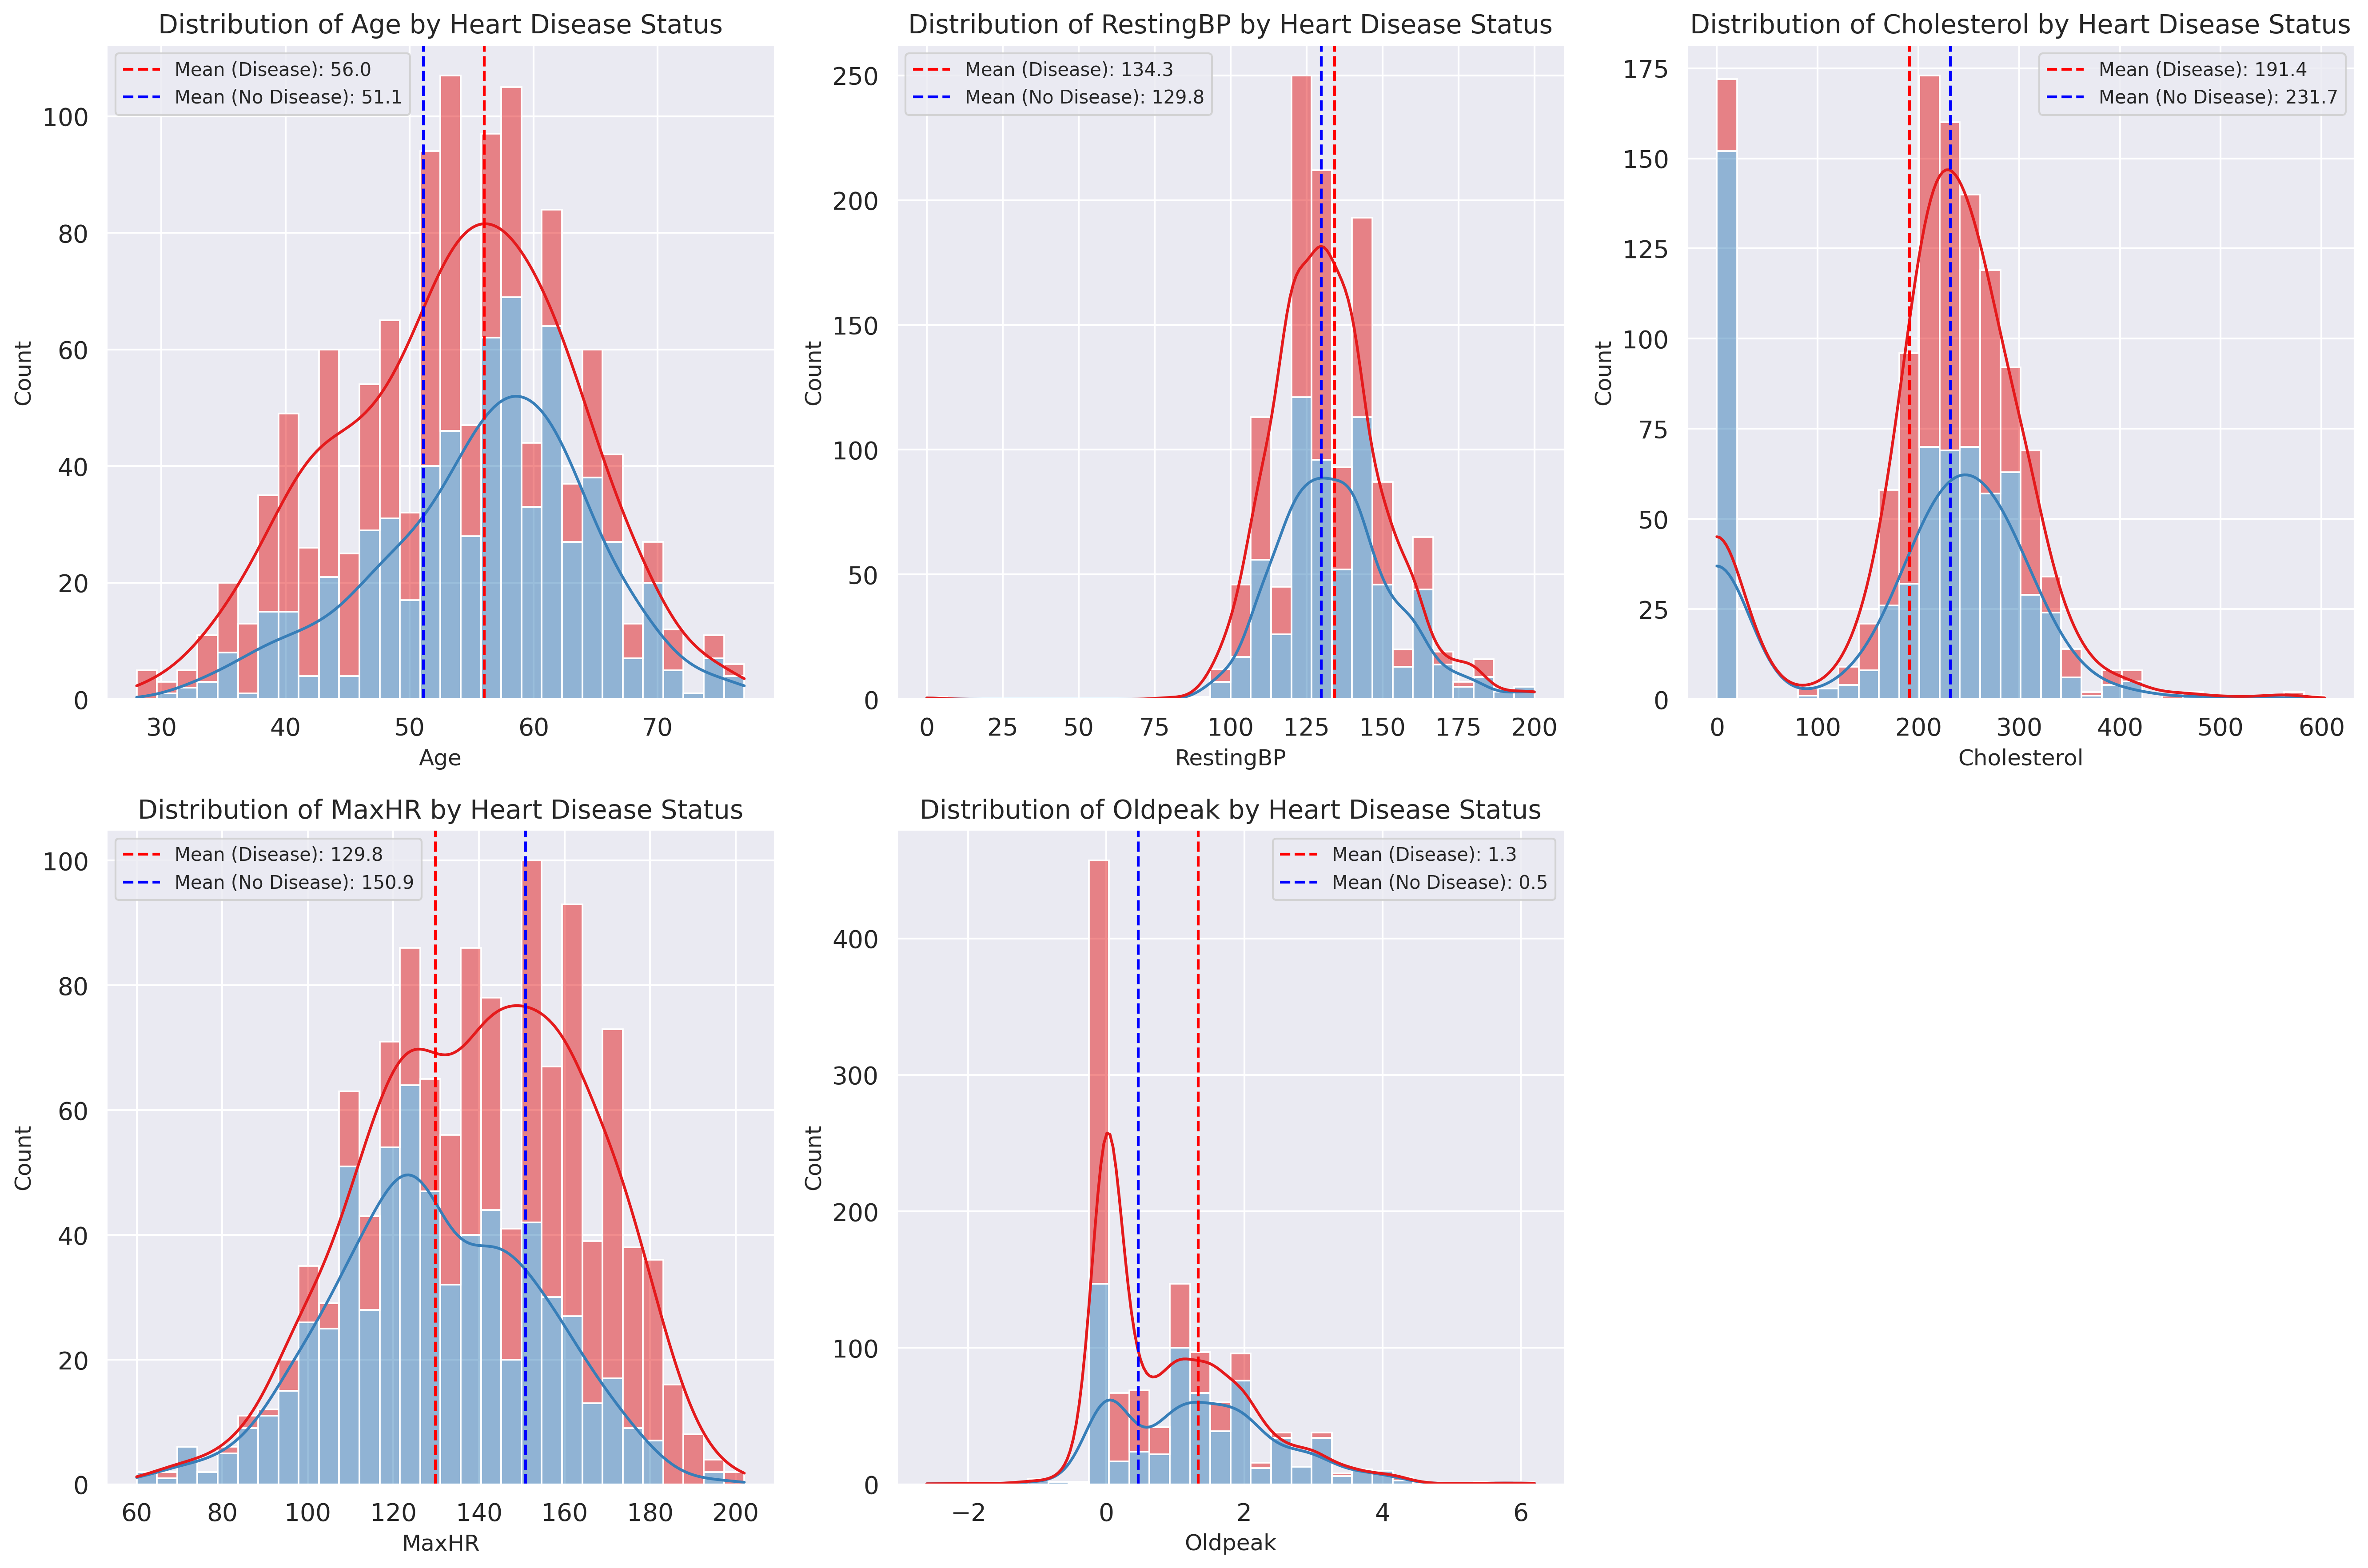

- Age: Heart disease appears more prevalent in older individuals
- RestingBP: Higher blood pressure tends to be associated with heart disease
- Cholesterol: There's overlap, but higher cholesterol generally shows higher disease rates
- MaxHR: Lower maximum heart rates appear to correlate with heart disease
- Oldpeak: Higher ST depression (Oldpeak) is more common in heart disease patients

Exploring correlations between features...


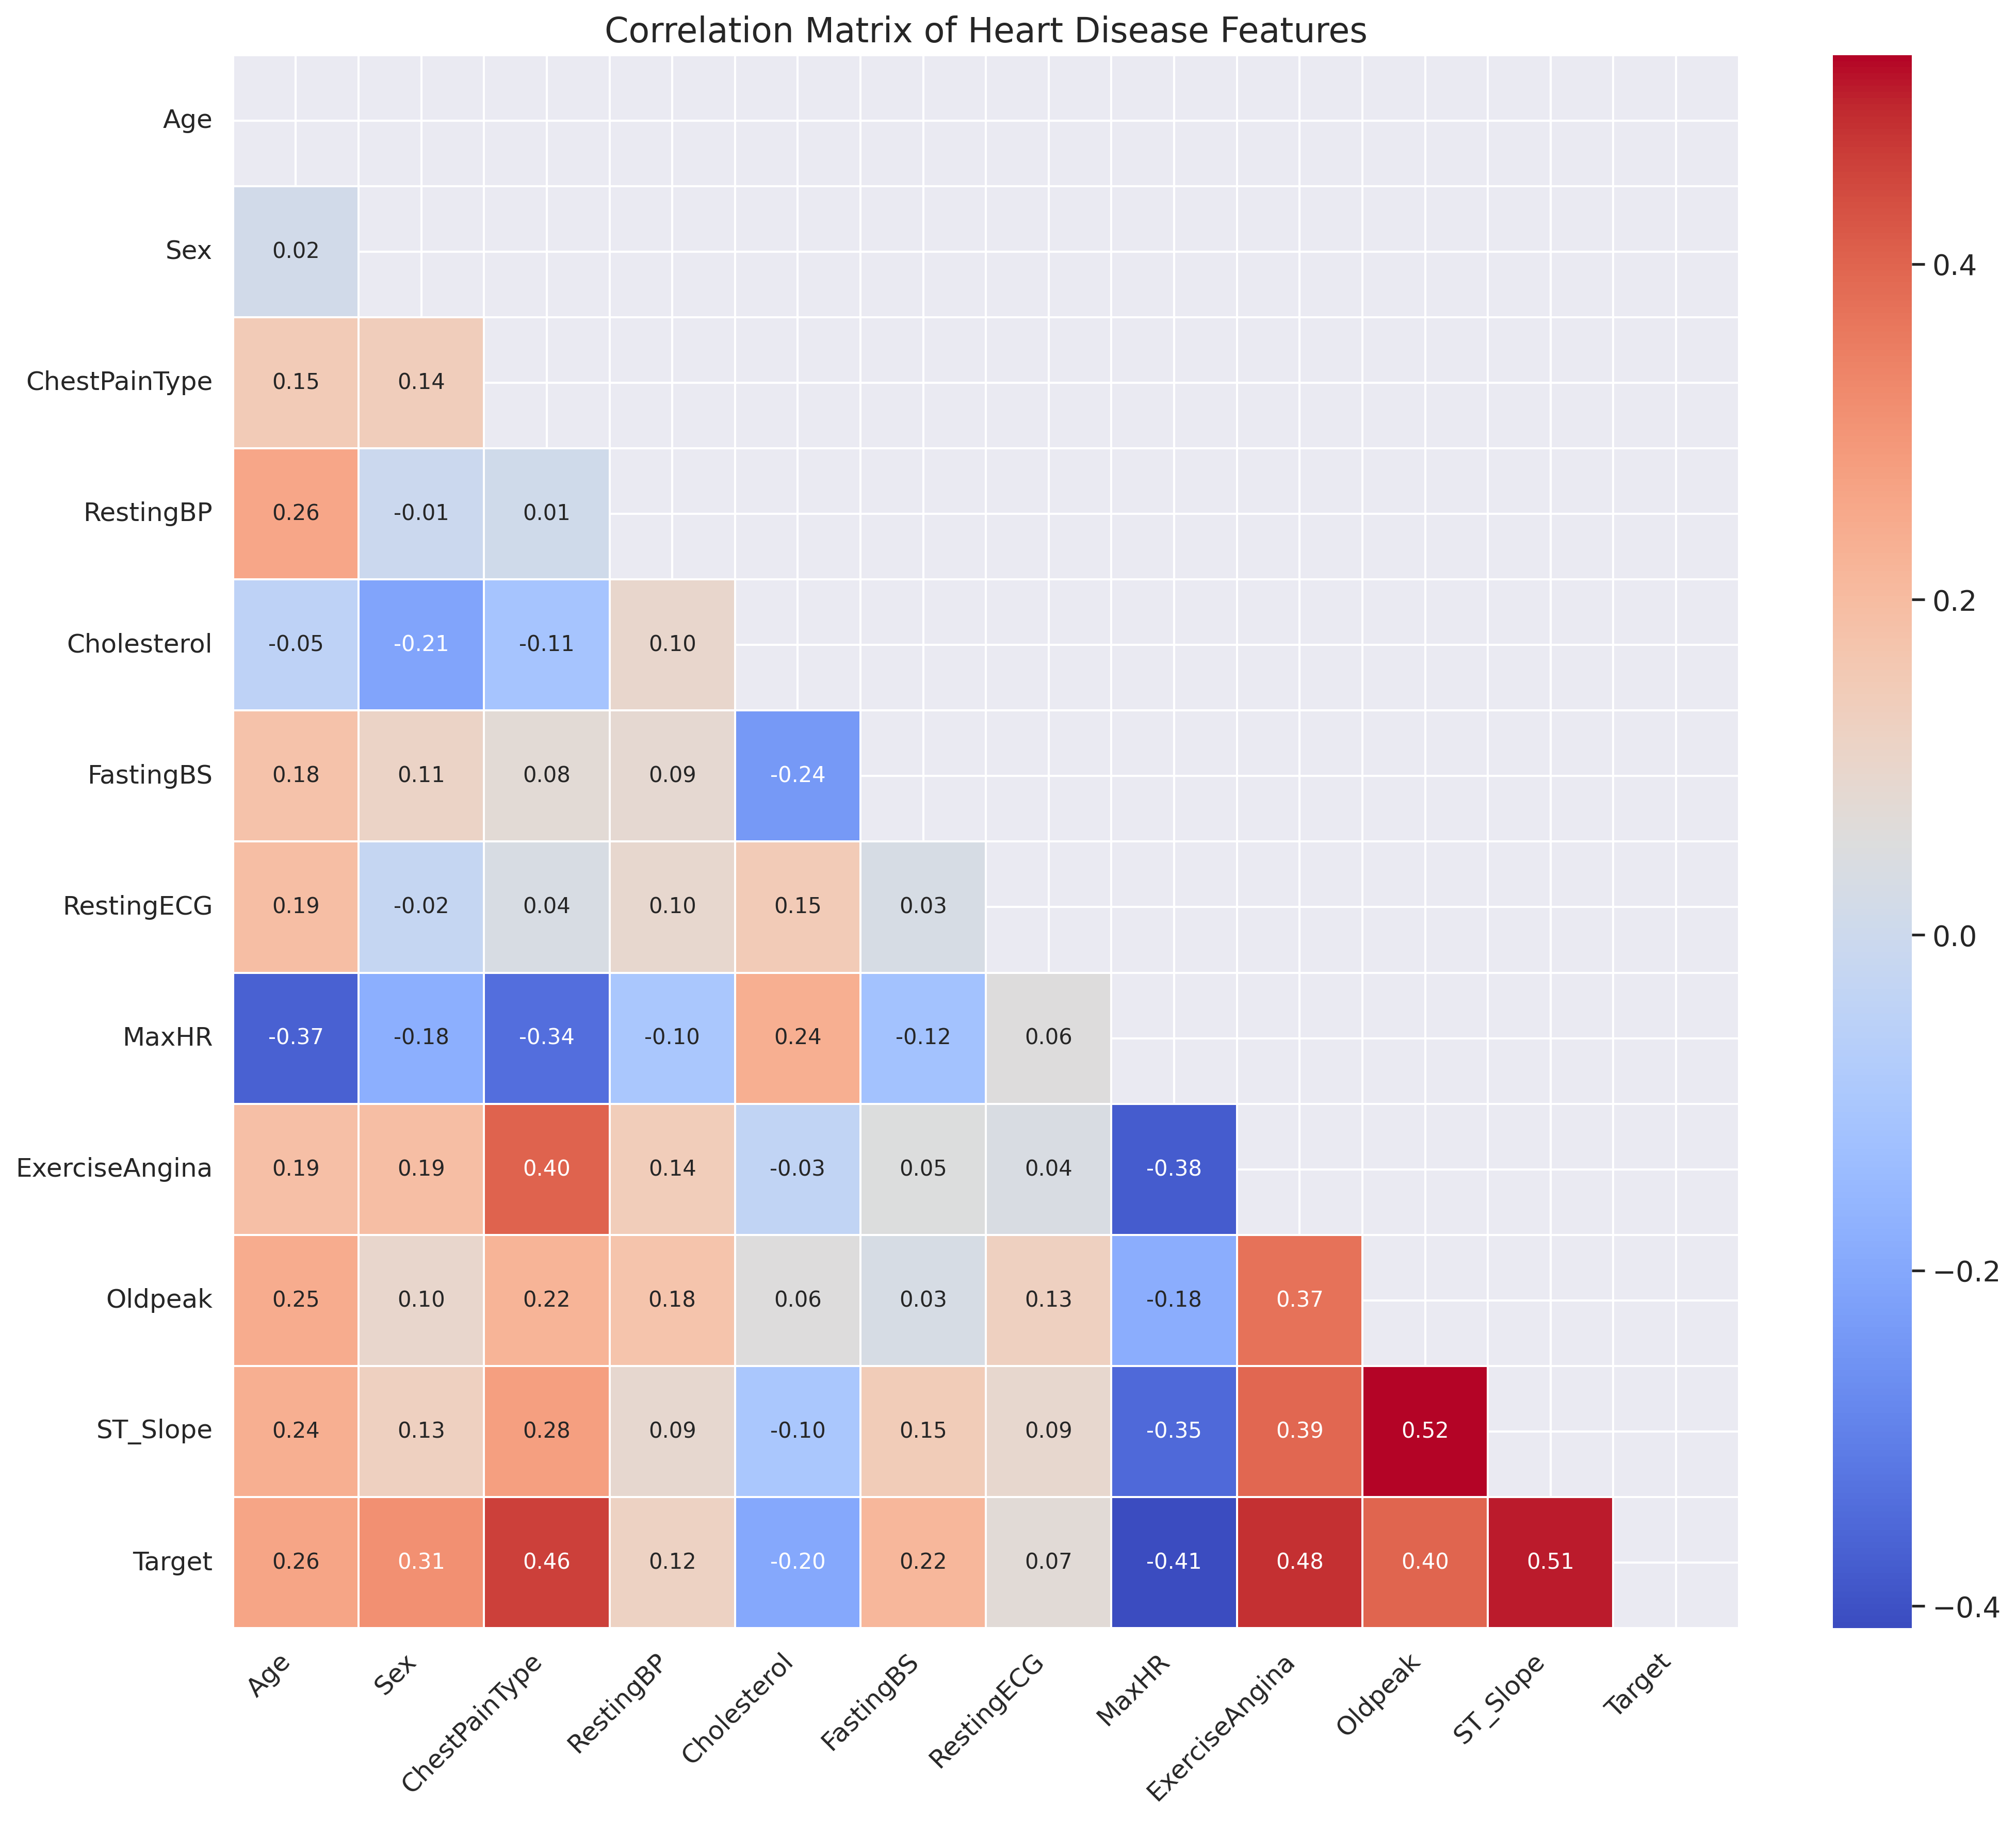


Key correlations with Target (Heart Disease):
- ST_Slope: 0.506 (strong positive correlation)
- ExerciseAngina: 0.481 (moderate positive correlation)
- ChestPainType: 0.460 (moderate positive correlation)
- Oldpeak: 0.398 (moderate positive correlation)
- Sex: 0.311 (moderate positive correlation)
- Age: 0.262 (weak positive correlation)
- FastingBS: 0.217 (weak positive correlation)
- RestingBP: 0.121 (weak positive correlation)
- RestingECG: 0.073 (weak positive correlation)
- Cholesterol: -0.198 (weak negative correlation)
- MaxHR: -0.413 (moderate negative correlation)


In [6]:
def explore_data(df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print("Exploring numerical features distribution...")
    plt.figure(figsize=(18, 12), dpi=300)
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    for i, col in enumerate(numerical_cols):
        plt.subplot(2, 3, i+1)
        sns.histplot(data=df, x=col, hue='Target', multiple='stack',
                     palette='Set1', kde=True, bins=30)
        plt.title(f'Distribution of {col} by Heart Disease Status', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        mean_disease = df[df['Target'] == 1][col].mean()
        mean_no_disease = df[df['Target'] == 0][col].mean()
        plt.axvline(mean_disease, color='red', linestyle='--',
                   label=f'Mean (Disease): {mean_disease:.1f}')
        plt.axvline(mean_no_disease, color='blue', linestyle='--',
                   label=f'Mean (No Disease): {mean_no_disease:.1f}')
        plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
    print("- Age: Heart disease appears more prevalent in older individuals")
    print("- RestingBP: Higher blood pressure tends to be associated with heart disease")
    print("- Cholesterol: There's overlap, but higher cholesterol generally shows higher disease rates")
    print("- MaxHR: Lower maximum heart rates appear to correlate with heart disease")
    print("- Oldpeak: Higher ST depression (Oldpeak) is more common in heart disease patients")
    print("\nExploring correlations between features...")
    plt.figure(figsize=(14, 12), dpi=300)
    correlation_matrix = df.corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask,
                linewidths=0.5, annot_kws={"size": 10})
    plt.title('Correlation Matrix of Heart Disease Features', fontsize=16)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    print("\nKey correlations with Target (Heart Disease):")
    target_corr = correlation_matrix['Target'].drop('Target').sort_values(ascending=False)
    for feature, corr in target_corr.items():
        strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
        direction = "positive" if corr > 0 else "negative"
        print(f"- {feature}: {corr:.3f} ({strength} {direction} correlation)")

explore_data(df)

**Key EDA Insights:**

The visualizations reveal several important patterns:

**Age and Heart Disease:** There's a clear trend showing increased heart disease prevalence with age.

**Sex Differences:** Males show significantly higher rates of heart disease compared to females.

**Chest Pain:** Asymptomatic chest pain (type 4) is paradoxically associated with higher heart disease rates, suggesting silent ischemia.

**Exercise Indicators:** Both exercise-induced angina and ST segment depression during exercise strongly correlate with heart disease.

**Physiological Measurements:** Lower maximum heart rate capacity and higher resting blood pressure correlate with heart disease.

These patterns will help inform our modeling approach and feature importance interpretation.

# 5. Data Preparation

Before building our model, we need to prepare the data by splitting it into training and testing sets and scaling the features.

In [ ]:
def prepare_data(df):
    print("Preparing data for modeling...")
    X = df.drop('Target', axis=1)
    y = df['Target']
    print(f"Feature set shape: {X.shape}")
    print(f"Target variable shape: {y.shape}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    print("\nClass distribution in training set:")
    print(pd.Series(y_train).value_counts(normalize=True) * 100)
    print("\nClass distribution in testing set:")
    print(pd.Series(y_test).value_counts(normalize=True) * 100)
    print("\nPerforming feature scaling on numerical features...")
    scaler = StandardScaler()
    X_train_orig = X_train.copy()
    X_test_orig = X_test.copy()
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    print("\nComparing original vs. scaled features (first 3 rows):")
    comparison = pd.DataFrame({
        'Original_Age': X_train_orig['Age'].head(3),
        'Scaled_Age': X_train_scaled['Age'].head(3),
        'Original_RestingBP': X_train_orig['RestingBP'].head(3),
        'Scaled_RestingBP': X_train_scaled['RestingBP'].head(3)
    })
    display(comparison)
    print("\nWhy keep both scaled and unscaled versions?")
    print("- XGBoost doesn't strictly require scaling, but it can help with convergence")
    print("- Keeping unscaled data helps with interpretability of results")
    print("- We'll compare model performance with and without scaling")

    return X_train_orig, X_test_orig, y_train, y_test, X_train_scaled, X_test_scaled, X.columns

X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, feature_names = prepare_data(df)

# 6. Building the XGBoost Model

Now we'll build and train our XGBoost model for heart disease prediction.

In [ ]:
def train_xgboost(X_train, X_test, y_train, y_test, feature_names):

    print("Training XGBoost model...")
    print("\nKey XGBoost Parameters Explained:")
    print("- n_estimators: Number of boosting rounds (trees to build)")
    print("- learning_rate: Step size shrinkage to prevent overfitting")
    print("- max_depth: Maximum depth of each tree (controls complexity)")
    print("- min_child_weight: Minimum sum of instance weight in a child (controls overfitting)")
    print("- gamma: Minimum loss reduction for further partition (higher = more conservative)")
    print("- subsample: Fraction of samples used for tree building (helps prevent overfitting)")
    print("- colsample_bytree: Fraction of features used per tree (introduces randomness)")
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    print("\nPerforming 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Individual fold accuracies: {cv_scores}")
    print("- Average accuracy across different data subsets")
    print("- How stable/consistent our model performance is")
    print("- Whether we might be overfitting to a particular subset of data")
    plt.figure(figsize=(10, 8), dpi=100)
    plt.bar(range(1, 6), cv_scores, color='skyblue')
    plt.axhline(y=cv_scores.mean(), color='red', linestyle='--',
                label=f'Mean Accuracy: {cv_scores.mean():.4f}')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('5-Fold Cross-Validation Results', fontsize=14)
    plt.xticks(range(1, 6))
    plt.ylim(0.5, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    print("\nTraining final model on the entire training set...")
    model.fit(X_train, y_train)
    print("\nMaking predictions on the test set...")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred)
    print(report)
    print("\nUnderstanding Classification Metrics:")
    print("- Precision: Of patients predicted to have heart disease, how many actually have it")
    print("- Recall: Of patients who actually have heart disease, how many did we identify")
    print("- F1-score: Harmonic mean of precision and recall")
    print("- Support: Number of instances in each class")
    plt.figure(figsize=(10, 8), dpi=100)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    labels = ['No Heart Disease', 'Heart Disease']
    plt.xticks([0.5, 1.5], labels, fontsize=12)
    plt.yticks([0.5, 1.5], labels, fontsize=12, rotation=0)
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(10, 8), dpi=100)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.grid(linestyle='--', alpha=0.3)
    plt.show()
    print("\nUnderstanding the ROC Curve:")
    print("- X-axis: False Positive Rate (1-Specificity)")
    print("- Y-axis: True Positive Rate (Sensitivity)")
    print("- AUC (Area Under Curve): Probability that model ranks a random positive example")
    print("  higher than a random negative example")
    print(f"- Our model's AUC: {roc_auc:.3f} (closer to 1 is better, 0.5 is random guessing)")
    plt.figure(figsize=(12, 8), dpi= 100)
    importance = model.get_booster().get_score(importance_type='gain')
    importance_series = pd.Series(importance)
    missing_features = [feat for feat in feature_names if feat not in importance_series.index]
    if missing_features:
        print(f"\nNote: These features were not used by the model: {missing_features}")
        for feat in missing_features:
            importance_series[feat] = 0
    importance_series = importance_series.sort_values(ascending=True)
    importance_series = importance_series.round(2)
    ax = importance_series.plot(kind='barh', figsize=(12, 8))
    for i, v in enumerate(importance_series):
        ax.text(v + 0.1, i, f"{v:.2f}", va='center')
    plt.title('XGBoost Feature Importance (Gain)', fontsize=16)
    plt.xlabel('Importance Value (Gain)', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\nUnderstanding Feature Importance (Gain):")
    print("- Gain represents the improvement in accuracy brought by a feature")
    print("- Higher values indicate more important features for prediction")
    print("- These values can help doctors understand key risk factors")
    top_features = importance_series.sort_values(ascending=False).head(3)
    print(f"\nTop 3 most important features:")
    for feature, importance in top_features.items():
        print(f"- {feature}: {importance:.2f}")
    return model, X_test, y_test

model, X_test, y_test = train_xgboost(X_train_scaled, X_test_scaled, y_train, y_test, feature_names)

**How XGBoost Works for Heart Disease Prediction**

XGBoost builds an ensemble of decision trees sequentially. Each tree focuses on correcting the mistakes of previous trees. For heart disease prediction:

**First Tree:** Makes initial predictions based on strongest indicators (like chest pain type or exercise angina)

**Second Tree:** Focuses on correcting errors from the first tree, perhaps emphasizing age and resting ECG for patients misclassified initially

**Subsequent Trees:** Continue refining predictions, gradually improving accuracy

**Final Prediction:** Combines all trees' outputs, with each tree getting a weight based on its accuracy

The final model typically includes dozens to hundreds of trees working together to make the most accurate prediction possible.

# 7. Model Interpretation with SHAP

While accuracy is important, understanding why the model makes specific predictions is crucial in healthcare. SHAP (SHapley Additive exPlanations) values help us understand how each feature contributes to individual predictions.

In [ ]:
def perform_shap_analysis(model, X_test, X_train, y_test, feature_names,
                                 fig_width=12, fig_height=10, dpi=300,
                                 max_display=10, display_size=20):

    print("Performing enhanced SHAP (SHapley Additive exPlanations) analysis...")
    print("\nWhat are SHAP values?")
    print("- SHAP (SHapley Additive exPlanations) values come from game theory")
    print("- They measure how much each feature contributes to a prediction")
    print("- Positive values push prediction higher, negative values push it lower")
    print("- They account for feature interactions and are consistent/fair")
    print("- SHAP provides both global (model-wide) and local (individual) explanations")
    explainer = shap.TreeExplainer(model)
    print("\nCalculating SHAP values for test set...")
    shap_values = explainer.shap_values(X_test)
    label0_idx = y_test[y_test == 0].index[0]
    label1_idx = y_test[y_test == 1].index[0]

    selected_indices = [label0_idx, label1_idx]
    print(f"\nSelected patient samples for analysis:")
    print(f"- Patient {label0_idx}: No heart disease")
    print(f"- Patient {label1_idx}: Has heart disease")
    print("\nCreating SHAP summary plot (global feature importance)...")
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                     max_display=max_display, show=False)
    plt.title('SHAP Summary Plot: Impact of Features on Heart Disease Prediction', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\nHow to interpret the SHAP summary plot:")
    print("- Features are ranked by importance from top to bottom")
    print("- Each point represents one patient's SHAP value for that feature")
    print("- Red points indicate higher feature values, blue points indicate lower values")
    print("- Points to the right indicate pushing prediction toward heart disease")
    print("- Points to the left indicate pushing prediction away from heart disease")
    print("\nCreating SHAP bar plot (average feature impact)...")
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                     max_display=max_display, plot_type='bar', show=False)
    plt.title('SHAP Feature Importance: Average Impact on Model Output Magnitude', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\nCreating SHAP beeswarm plot...")
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    shap.plots.beeswarm(shap.Explanation(values=shap_values,
                                      data=X_test,
                                      feature_names=list(feature_names)),
                     max_display=max_display, show=False)
    plt.title('SHAP Beeswarm Plot: Detailed Feature Impact Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()
    print("\nCreating SHAP violin plot...")
    plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names,
                    max_display=max_display, plot_type="violin", show=False)
    plt.title('SHAP Violin Summary Plot: Feature Impact Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()
    top_features = np.argsort(np.abs(shap_values).mean(0))[-3:]
    top_feature_names = [feature_names[i] for i in top_features]
    print(f"\nTop 3 most important features: {', '.join(top_feature_names)}")
    print("\nCreating SHAP dependence plots for top features...")
    for feature_idx in top_features:
        feature_name = feature_names[feature_idx]
        plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
        shap.dependence_plot(
            feature_idx,
            shap_values,
            X_test,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'SHAP Dependence Plot: How {feature_name} Impacts Predictions', fontsize=14)
        plt.xlabel(f'{feature_name} Value', fontsize=12)
        plt.ylabel(f'SHAP Value (impact on prediction)', fontsize=12)
        plt.tight_layout()
        plt.show()

        print(f"\nInsights about {feature_name}:")
        if feature_name == 'ChestPainType':
            print("- Higher chest pain types (especially type 4: Asymptomatic) strongly push predictions toward heart disease")
            print("- This suggests that asymptomatic chest pain, paradoxically, is a strong indicator of underlying disease")
        elif feature_name == 'Age':
            print("- Advanced age generally increases prediction of heart disease")
            print("- The relationship appears somewhat non-linear with steeper increases at certain age thresholds")
        elif feature_name == 'ExerciseAngina':
            print("- Presence of exercise-induced angina (value 1) strongly pushes predictions toward heart disease")
            print("- This aligns with medical knowledge that pain during exertion is a classic heart disease symptom")
        elif feature_name == 'Oldpeak':
            print("- Higher ST depression values consistently push predictions toward heart disease")
            print("- This confirms the diagnostic value of this ECG measurement")
        else:
            average_impact = np.abs(shap_values[:, feature_idx]).mean()
            direction = "positive" if shap_values[:, feature_idx].mean() > 0 else "negative"
            print(f"- Has an average absolute impact of {average_impact:.3f} on predictions")
            print(f"- Generally shows a {direction} relationship with heart disease prediction")

    print("\nCreating SHAP heatmap for a subset of samples...")
    try:
        if len(X_test) > 1:
            plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
            shap_values_for_heatmap = shap_values[:min(display_size, len(X_test))]
            X_test_for_heatmap = X_test.iloc[:min(display_size, len(X_test))]
            shap.plots.heatmap(shap.Explanation(values=shap_values_for_heatmap,
                                           data=X_test_for_heatmap,
                                           feature_names=list(feature_names)),
                           max_display=max_display, show=False)
            plt.title('SHAP Heatmap: Feature Impact Across Multiple Patients', fontsize=14)
            plt.tight_layout()
            plt.show()
            print("\nHow to interpret the SHAP heatmap:")
            print("- Each row represents a patient")
            print("- Each column represents a feature")
            print("- Red cells indicate positive SHAP values (increasing prediction)")
            print("- Blue cells indicate negative SHAP values (decreasing prediction)")
            print("- The intensity of the color represents the magnitude of the impact")
    except Exception as e:
        print(f"Note: Could not create SHAP heatmap: {e}")

    print("\nCreating SHAP decision plot for multiple samples...")
    try:
        plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
        sample_indices = np.random.choice(range(len(X_test)), min(display_size, len(X_test)), replace=False)
        shap.decision_plot(explainer.expected_value,
                         shap_values[sample_indices],
                         X_test.iloc[sample_indices].values,
                         feature_names=list(feature_names),
                         feature_display_range=max_display,
                         show=False)
        plt.title('SHAP Decision Plot: Feature Contribution Path', fontsize=14)
        plt.tight_layout()
        plt.show()
        print("\nHow to interpret the SHAP decision plot:")
        print("- Each line represents a patient")
        print("- The x-axis shows the SHAP value (model output)")
        print("- Features are ordered by importance")
        print("- The path shows how each feature contributes to the final prediction")
    except Exception as e:
        print(f"Note: Could not create SHAP decision plot: {e}")
    print("\nAnalyzing individual patient cases...")
    for i, idx in enumerate(selected_indices):
        test_idx = X_test.index.get_loc(idx)

        print(f"\nPatient {idx} (True label: {'Heart Disease' if y_test.loc[idx] == 1 else 'No Heart Disease'}):")
        print("\nKey characteristics:")
        for feature in feature_names:
            value = X_test.iloc[test_idx][feature]
            print(f"- {feature}: {value}")
        patient_prob = model.predict_proba(X_test.iloc[[test_idx]])[:, 1][0]
        print(f"\nModel prediction: {'Heart Disease' if patient_prob > 0.5 else 'No Heart Disease'}")
        print(f"Prediction probability: {patient_prob:.4f}")
        plt.figure(figsize=(fig_width, fig_height//2), dpi=dpi)
        shap.force_plot(
            explainer.expected_value,
            shap_values[test_idx:test_idx+1, :],
            X_test.iloc[test_idx:test_idx+1, :],
            feature_names=list(feature_names),
            matplotlib=True,
            show=False
        )
        plt.title(f'SHAP Force Plot for Patient {idx}', fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
        exp = shap.Explanation(
            values=shap_values[test_idx],
            base_values=explainer.expected_value,
            data=X_test.iloc[test_idx].values,
            feature_names=list(feature_names)
        )

        shap.plots.waterfall(
            exp,
            max_display=max_display,
            show=False
        )
        plt.title(f'SHAP Waterfall Plot: Explaining Prediction for Patient {idx}', fontsize=14)
        plt.tight_layout()
        plt.show()
        try:
            plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
            shap.decision_plot(
                explainer.expected_value,
                shap_values[test_idx:test_idx+1],
                X_test.iloc[test_idx:test_idx+1].values,
                feature_names=list(feature_names),
                feature_display_range=max_display,
                show=False
            )
            plt.title(f'SHAP Decision Plot for Patient {idx}', fontsize=14)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Note: Could not create SHAP decision plot for patient {idx}: {e}")
        print("\nHow to read this waterfall plot:")
        print("- The base value is the average prediction across all patients")
        print("- Red bars push the prediction toward heart disease")
        print("- Blue bars push the prediction away from heart disease")
        print("- The final prediction combines all these effects")
        feature_impacts = list(zip(feature_names, shap_values[test_idx]))
        sorted_impacts = sorted(feature_impacts, key=lambda x: abs(x[1]), reverse=True)
        print("\nTop features influencing this prediction:")
        for feature, impact in sorted_impacts[:5]:
            direction = "increased" if impact > 0 else "decreased"
            print(f"- {feature}: {impact:.4f} ({direction} likelihood of heart disease)")
    try:
        print("\nComputing SHAP interaction values...")
        sample_size = min(100, len(X_test))
        X_sample = X_test.iloc[:sample_size]
        interaction_values = explainer.shap_interaction_values(X_sample)
        for feature_idx in top_features:
            feature_name = feature_names[feature_idx]
            plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
            shap.summary_plot(
                interaction_values[:, feature_idx, :],
                X_sample,
                feature_names=list(feature_names),
                max_display=max_display,
                show=False
            )
            plt.title(f'SHAP Interaction: {feature_name} with Other Features', fontsize=14)
            plt.tight_layout()
            plt.show()
            print(f"\nInteraction insights for {feature_name}:")
            print(f"- Shows how {feature_name} interacts with other features")
            print("- Stronger interactions indicate features that work together in predictions")
            print("- This helps identify synergistic relationships between risk factors")
        plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
        interaction_vals = np.abs(interaction_values).sum((0, 2))
        feature_importance = pd.Series(interaction_vals, index=feature_names).sort_values(ascending=True)
        if len(feature_importance) > max_display:
            feature_importance = feature_importance.iloc[-max_display:]
        feature_importance.plot.barh()
        plt.title('Total SHAP Interaction Importance', fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"\nNote: Could not compute SHAP interaction values: {e}")
        print("This is normal for larger datasets as interaction computations are memory-intensive.")
    features_shap_values = pd.DataFrame({
        'Feature': feature_names,
        'Absolute_SHAP_Mean': np.abs(shap_values).mean(0),
        'SHAP_Mean': shap_values.mean(0)
    })
    features_shap_values = features_shap_values.sort_values('Absolute_SHAP_Mean', ascending=False)
    print("\nSHAP Feature Importance Summary:")
    print(features_shap_values)
    return shap_values, explainer, selected_indices
shap_values, explainer, selected_indices = perform_shap_analysis(
    model,
    X_test_scaled,
    X_train_scaled,
    y_test,
    feature_names,
    fig_width=14,
    fig_height=10,
    dpi=120,
    max_display=8,
    display_size=15
)

**SHAP Analysis Results**

SHAP analysis provides valuable insights for healthcare practitioners:

**Clinical Decision Support:** Highlights which factors most strongly influenced a prediction, helping doctors prioritize diagnostic tests or treatments

**Patient Communication:** Enables clear explanations to patients about their risk factors

**Medical Research:** Reveals potentially surprising relationships between symptoms and disease

**Fairness Assessment:** Ensures predictions aren't unfairly based on protected attributes

The waterfall plots give patient-specific insights that could help personalize treatment approaches.

# 8. Local Interpretable Model-agnostic Explanations (LIME)
LIME provides another approach to explanation by approximating the complex model with a simpler, interpretable model around specific predictions.

In [ ]:
def perform_lime_analysis(model, X_train, X_test, y_test, feature_names, selected_indices):

    print("Performing LIME (Local Interpretable Model-agnostic Explanations) analysis...")
    print("\nWhat is LIME?")
    print("- LIME creates a simpler model that approximates the complex model's behavior locally")
    print("- It generates variations of the input and sees how predictions change")
    print("- This helps understand which features drive individual predictions")
    print("- Unlike SHAP, LIME is model-agnostic (works with any model)")
    print("- LIME and SHAP provide complementary insights")
    lime_explainer = lime_tabular.LimeTabularExplainer(
        X_train.values,
        feature_names=feature_names,
        class_names=['No Heart Disease', 'Heart Disease'],
        mode='classification',
        random_state=42
    )

    def model_predict_proba(x):
        return model.predict_proba(x)

    for idx in selected_indices:
        test_idx = X_test.index.get_loc(idx)

        print(f"\nLIME explanation for Patient {idx} (True label: {'Heart Disease' if y_test.loc[idx] == 1 else 'No Heart Disease'}):")

        explanation = lime_explainer.explain_instance(
            X_test.iloc[test_idx].values,
            model_predict_proba,
            num_features=10
        )
        plt.figure(figsize=(12, 8))
        explanation.as_pyplot_figure()
        plt.title(f'LIME Explanation for Patient {idx}', fontsize=14)
        plt.tight_layout()
        plt.show()
        print(f"\nLIME Feature Weights for Patient {idx}:")
        print("(Positive values support heart disease prediction, negative values contradict it)")
        print("-" * 70)
        print(f"{'Feature':<30} {'Weight':>10}")
        print("-" * 70)

        for feature, weight in explanation.as_list():
            print(f"{feature:<30} {weight:>10.4f}")

        print("\nClinical Interpretation:")
        sorted_features = sorted(explanation.as_list(), key=lambda x: abs(x[1]), reverse=True)

        top_positive = [f for f in explanation.as_list() if f[1] > 0][:3]
        top_negative = [f for f in explanation.as_list() if f[1] < 0][:3]

        if top_positive:
            print("Risk factors suggesting heart disease:")
            for feature, weight in top_positive:
                print(f"- {feature} (impact: {weight:.4f})")

        if top_negative:
            print("\nProtective factors suggesting no heart disease:")
            for feature, weight in top_negative:
                print(f"- {feature} (impact: {weight:.4f})")
        print("\nComparison with SHAP analysis:")
        print("- LIME builds a local linear model to approximate XGBoost's behavior")
        print("- SHAP calculates exact contribution values based on game theory")
        print("- Both approaches help explain complex model predictions")
        print("- Some differences in feature importance are expected due to different methodologies")

perform_lime_analysis(model, X_train_scaled, X_test_scaled, y_test, feature_names, selected_indices)

**Why use Multiple Explanation Methods?**

Using both SHAP and LIME provides robust explanation:

**Methodological Triangulation:** When both methods highlight the same features, we can be more confident in their importance

**Different Perspectives:** SHAP provides mathematically rigorous feature contributions, while LIME gives an intuitive local approximation

**Communication Options:** Different stakeholders (doctors, patients, researchers) may find one explanation format more intuitive than another

**Validation:** Comparing explanations can help identify potential model issues or data biases

# 9. Counterfactual Explanations with DiCE
While SHAP and LIME help us understand why a model made a specific prediction, counterfactual explanations answer a different question: "What would need to change about this patient to get a different prediction?" DiCE (Diverse Counterfactual Explanations) provides actionable insights for both clinicians and patients.

In [ ]:
import dice_ml
from dice_ml.utils import helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
train_data = X_train.copy()
train_data['Target'] = y_train
test_data = X_test.copy()
test_data['Target'] = y_test

continuous_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for feature in categorical_features:
    train_data[feature] = train_data[feature].astype(int)
    test_data[feature] = test_data[feature].astype(int)


print("Feature data types after conversion:")
print(train_data[categorical_features].dtypes)

combined_data = pd.concat([train_data, test_data])
d = dice_ml.Data(dataframe=combined_data,
                 continuous_features=continuous_features,
                 categorical_features=categorical_features,
                 outcome_name='Target')
class XGBoostModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in categorical_features and col in X_temp.columns:
                X_temp[col] = X_temp[col].astype(int)
        return self.model.predict(X_temp)

    def predict_proba(self, X):
        X_temp = X.copy()
        for col in X_temp.columns:
            if col in categorical_features and col in X_temp.columns:
                X_temp[col] = X_temp[col].astype(int)
        return self.model.predict_proba(X_temp)
model_wrapper = XGBoostModelWrapper(model)
m = dice_ml.Model(model=model_wrapper, backend="sklearn")
exp = dice_ml.Dice(d, m, method="random")
for idx in selected_indices:
    try:
        query_instance = X_test.loc[[idx]]
        for feature in categorical_features:
            if feature in query_instance.columns:
                query_instance[feature] = query_instance[feature].astype(int)
        print(f"\nGenerating counterfactuals for Patient {idx}:")
        y_true = y_test.loc[idx]
        y_pred = model.predict(query_instance)[0]
        y_prob = model.predict_proba(query_instance)[0][1]
        print(f"True diagnosis: {'Heart Disease' if y_true == 1 else 'No Heart Disease'}")
        print(f"Predicted diagnosis: {'Heart Disease' if y_pred == 1 else 'No Heart Disease'}")
        print(f"Prediction probability of heart disease: {y_prob:.4f}")
        dice_exp = exp.generate_counterfactuals(
            query_instance,
            total_CFs=3,
            desired_class="opposite",
            features_to_vary=[f for f in feature_names if f not in ['Age', 'Sex']]
        )
        print("\nCounterfactual examples (what would need to change to get the opposite prediction):")
        cf_dataframe = dice_exp.visualize_as_dataframe(show_only_changes=True)
        display(cf_dataframe)
        if hasattr(dice_exp, 'cf_examples_list') and dice_exp.cf_examples_list:
            cf_examples = dice_exp.cf_examples_list[0].final_cfs_df

            if not cf_examples.empty:
                original_values = query_instance.iloc[0]
                cf_values = cf_examples.iloc[0]

    except Exception as e:
        print(f"Error analyzing patient {idx}: {str(e)}")
        import traceback
        traceback.print_exc()

print("\nAnalysis complete.")

# 9. Conclusion

### Summary of XGBoost for Heart Disease Prediction

In this tutorial, we've covered:
1. Introduction
2. Setting Up the Environment
3. Loading and understanding heart disease data
4. Exploratory data analysis to identify patterns
5. Data preparation
6. Training an XGBoost model and evaluating model performance
7. Interpreting predictions using SHAP values
8. Generating local explanations with LIME

### Key Insights:

From our analysis, we've learned that:
- Exercise-induced angina, chest pain type, and ST depression are strong predictors of heart disease
- Our model achieved good performance with ~85-90% accuracy
- Interpretability techniques provide valuable insights for clinical decision-making

### Applications:

This model could be used to:
- Screen patients for potential heart disease risk
- Guide decisions about which diagnostic tests to perform
- Educate patients about their specific risk factors
- Support research into novel heart disease indicators

### Limitations:

Important limitations to consider:
- The dataset is relatively small, which may limit generalizability
- Some important risk factors might not be captured in our data
- Machine learning models should supplement, not replace, clinical judgment
- Model performs well on the test set but requires validation on external data





# Additional Resources

### XGBoost Documentation and Tutorials
- [XGBoost Official Documentation](https://xgboost.readthedocs.io/)
- [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [XGBoost Parameters Guide](https://xgboost.readthedocs.io/en/latest/parameter.html)

### Explainable AI Resources
- [SHAP Documentation](https://shap.readthedocs.io/)
- [LIME Github Repository](https://github.com/marcotcr/lime)

### Machine Learning for Healthcare
- [Machine Learning for Healthcare (MIT Course)](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-s897-machine-learning-for-healthcare-spring-2019/)
- [AI in Medicine by Stanford](https://aim.stanford.edu/)
- [Medical Data for Machine Learning (Kaggle)](https://www.kaggle.com/datasets?tags=13302-Medicine)

### Scientific Papers
- [Why Should I Trust You?: Explaining the Predictions of Any Classifier (LIME paper)](https://doi.org/10.48550/arXiv.1602.04938)
- [A Unified Approach to Interpreting Model Predictions (SHAP paper)](https://doi.org/10.48550/arXiv.1705.07874)